In [1]:
import jax

jax.config.update("jax_default_matmul_precision", "float32")

In [2]:
import rioxarray
import xarray
import pandas

import jax.numpy as jnp
import glaunti.ti_corr_model as model
import dataloader.dataloader as dataloader
import core.loss as loss
import core.training as training
import utils.serialise
import utils.logger
import constants

import matplotlib.pyplot as plt
import numpy as np
import pyproj

import sklearn.metrics
import scipy

In [3]:
from tqdm import tqdm

In [4]:
glacier = "Grosser Aletsch"

In [5]:
dataset_index = dataloader.retrieve_dataset_index()
glacier = dataset_index[dataset_index.name == glacier].iloc[0]

In [6]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(trainable_params, static_params, x, initial_swe, False, True)
    )
)

In [7]:
trainable_params, static_params = model.get_initial_model_parameters(ti_params_static=False)
trainable_params, static_params

({'corrector': Corrector(
    branch_2d=Corrector2dBranch(
      in_conv=Conv2d(
        num_spatial_dims=2,
        weight=f32[32,12,1,1],
        bias=f32[32,1,1],
        in_channels=12,
        out_channels=32,
        kernel_size=(1, 1),
        stride=(1, 1),
        padding='SAME',
        dilation=(1, 1),
        groups=1,
        use_bias=True,
        padding_mode='ZEROS'
      ),
      downs=(
        Down(
          block=DoubleConv2d(
            block1=Conv2dINAct(
              conv=Conv2d(
                num_spatial_dims=2,
                weight=f32[32,32,3,3],
                bias=f32[32,1,1],
                in_channels=32,
                out_channels=32,
                kernel_size=(3, 3),
                stride=(1, 1),
                padding='SAME',
                dilation=(1, 1),
                groups=1,
                use_bias=True,
                padding_mode='ZEROS'
              ),
              norm=GroupNorm(
                groups=32,
               

In [8]:
loss_grad = jax.value_and_grad(loss.loss, argnums=0, has_aux=True)

In [9]:
optimiser = training.get_optimiser()
opt_state = optimiser.init(trainable_params)

In [10]:
logger = None

In [11]:
with tqdm(total=constants.n_epochs, desc=glacier["name"]) as pbar:
    for epoch in range(constants.n_epochs):
        (loss_value, aux), grads = loss_grad(
            trainable_params, static_params, model_callable, 
            glacier, 
            ti=True,
            ti_corr=True,
        )

        trainable_params, opt_state = training.make_step(optimiser, grads, trainable_params, opt_state)
        
        pbar.set_description(f"{glacier['name']}, loss={loss_value:.3f}")
        log_record = {"epoch": epoch, "glacier": glacier["name"], "loss": loss_value, **aux}
        if logger is None:
            logger = utils.logger.CSVLogger(f"mock_{glacier['name']}_log.csv", log_record.keys())
        logger.log(log_record)

        pbar.update(1)

Grosser Aletsch, loss=1.072: 100%|████████████████████████████████████████████████████████████████| 100/100 [26:44<00:00, 16.04s/it]


In [12]:
utils.serialise.save_pytree((trainable_params, static_params), f"mock_{glacier['name']}_TI_params.eqx")

In [13]:
trainable_params, static_params = utils.serialise.load_pytree(f"mock_{glacier['name']}_TI_params.eqx", template=(trainable_params, static_params))

In [14]:
model.resolve_param_constraints({**trainable_params, **static_params})

AttributeError: module 'glaunti.ti_corr_model' has no attribute 'resolve_param_constraints'

In [15]:
model_callable = jax.jit(
    jax.remat(
        lambda trainable_params, static_params, x, initial_swe: model.run_model(
            trainable_params, static_params, x, initial_swe, True, True
        )
    )
)

swe_or_h, next_xy = loss.init_swe_or_h(
    trainable_params, static_params, model_callable, glacier["name"], True, False
)

smb_results, ts, ps, outlines = [], [], [], []

for year in tqdm(range(constants.study_period_start_year, glacier.max_year + 1)):
    x, y = next_xy.get()
    next_xy = dataloader.prefetch_xy(
        glacier["name"], year + 1, 
        retrieve_corrector_predictors=True, 
        retrieve_facies=False,
    )
    if "annual" in x:
        ts.append(x["annual"]["temperature"])
        ps.append(x["annual"]["precipitation"])
    else:
        ts.append(x["winter"]["temperature"])
        ps.append(x["winter"]["precipitation"])
        ts.append(x["summer"]["temperature"])
        ps.append(x["summer"]["precipitation"])
    outlines.append(x["outlines"])
    x = dataloader.x_to_raw_numpy(x)

    if "annual" in x:
        x_annual = {k: v for k, v in x.items() if k != "annual"}
        x_annual.update(x["annual"])
        smb, swe_or_h, _ = model_callable(trainable_params, static_params, x_annual, swe_or_h)
        smb_results.append(np.array(smb))
        
    else:
        x_winter = {k: v for k, v in x.items() if k not in {"winter", "summer"}}
        x_winter.update(x["winter"])
        smb, swe_or_h, _ = model_callable(trainable_params, static_params, x_winter, swe_or_h)
        smb_results.append(np.array(smb))

        x_summer = {k: v for k, v in x.items() if k not in {"winter", "summer"}}
        x_summer.update(x["summer"])
        smb, swe_or_h, _ = model_callable(trainable_params, static_params, x_summer, swe_or_h)
        smb_results.append(np.array(smb))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:35<00:00,  3.17s/it]


In [16]:
smb_xrs = []
for t, smb_r in zip(ts, smb_results):
    smb_xr = t.copy()
    smb_xr.data = smb_r
    smb_xr = smb_xr.rename("smb")
    smb_xrs.append(smb_xr)

In [17]:
temperature = xarray.concat(ts, dim="time", join="exact").sortby("time").groupby("time").mean("time")
precipitation = xarray.concat(ps, dim="time", join="exact").sortby("time").groupby("time").mean("time")
outlines = xarray.concat(outlines, dim="year", join="exact").sortby("year")
smb_xr = xarray.concat(smb_xrs, dim="time", join="exact").sortby("time").groupby("time").sum("time")

In [18]:
smb_total = pandas.read_csv(f"data/{glacier['name']}/total_smb.csv")
smb_point = pandas.read_csv(f"data/{glacier['name']}/point_smb.csv")

smb_total = smb_total[(smb_total.name == glacier['name']) & (smb_total.year >= 1995)]
smb_point = smb_point[(smb_point.name == glacier['name']) & (smb_point.year >= 1995)]

In [19]:
smb_xr.to_netcdf(f"../../dirty/{glacier['name']}_test.nc", engine="netcdf4")

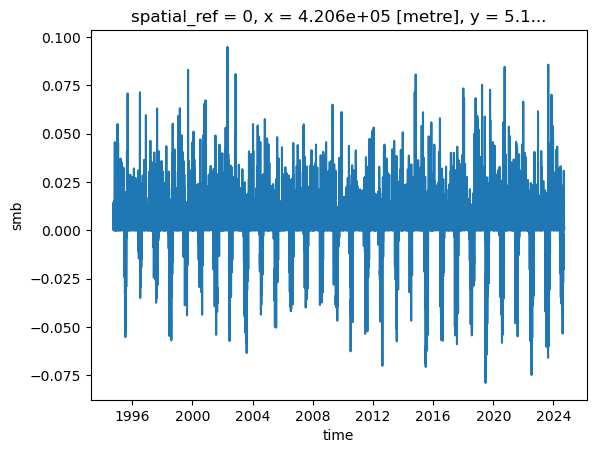

In [20]:
smb_xr[:, 40, 40].plot()

In [21]:
total_model = {"winter": [], "summer": [], "annual": []}
total_wgms = {"winter": [], "summer": [], "annual": []}
point_model = {"winter": [], "summer": [], "annual": []}
point_wgms = {"winter": [], "summer": [], "annual": []}


transformer = pyproj.Transformer.from_crs("EPSG:4326", smb_xr.rio.crs, always_xy=True)


for year in tqdm(range(1995, 2025)):
    # compile glacier-wide estimates
    yr_total_smb = smb_total[smb_total.year == year].iloc[0]
    yr_outlines = outlines.sel(year=year)

    annual_smb_subset = smb_xr.sel(time=slice(yr_total_smb["begin_date"], yr_total_smb["end_date"]))
    annual_smb_model = (annual_smb_subset * yr_outlines).sum() / yr_outlines.sum()
    total_model["annual"].append(annual_smb_model)
    total_wgms["annual"].append(yr_total_smb["annual_balance"])
    
    if not (isinstance(yr_total_smb["midseason_date"], float) and np.isnan(yr_total_smb["midseason_date"])):
        winter_smb_subset = smb_xr.sel(time=slice(yr_total_smb["begin_date"], yr_total_smb["midseason_date"]))
        winter_smb_model = (winter_smb_subset * yr_outlines).sum() / yr_outlines.sum()
        total_model["winter"].append(winter_smb_model)
        total_wgms["winter"].append(yr_total_smb["winter_balance"])
        
        summer_smb_subset = smb_xr.sel(time=slice(yr_total_smb["midseason_date"], yr_total_smb["end_date"]))
        summer_smb_model = (summer_smb_subset * yr_outlines).sum() / yr_outlines.sum()
        total_model["summer"].append(summer_smb_model)
        total_wgms["summer"].append(yr_total_smb["summer_balance"])

    # compile point estimates
    yr_point_smb = smb_point[smb_point.year == year]
    for m in yr_point_smb.itertuples():
        if m.balance_code == "index":
            continue
        smb_subset = smb_xr.sel(time=slice(m.begin_date, m.end_date))
        x, y = transformer.transform(m.longitude, m.latitude)
        smb_subset = smb_subset.sel(x=x, y=y, method="nearest")
        point_model[m.balance_code].append(smb_subset.sum())
        point_wgms[m.balance_code].append(m.balance)

        # from rasterio.transform import rowcol

        # # get row/col for the *nearest* cell (op=round); default is floor
        # r, c = rowcol(da.rio.transform(), x, y, op=round)
        
        # # clamp to bounds just in case
        # r = max(0, min(r, da.sizes["y"] - 1))
        # c = max(0, min(c, da.sizes["x"] - 1))
        
        # pix = da.isel(y=r, x=c)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 10.25it/s]


In [22]:
for title, pred, gt in [("point", point_model, point_wgms), ("glacier-wide", total_model, total_wgms)]:
    print(title)
    for group in ["winter", "summer", "annual"]:
        if len(gt[group]) >= 2:
            print(f"\t{group}")
            y_hat = np.array(pred[group])
            y = np.array(gt[group])
    
            r, _ = scipy.stats.pearsonr(y_hat, y)
            print(f"\t\tPearson r = {r:.3f}")
    
            bias = np.mean(y_hat - y)
            print(f"\t\tBias = {bias:.3f}")
    
            rmse = np.sqrt(np.mean((y_hat - y)**2))
            print(f"\t\tRMSE = {rmse:.3f}")
    
            mae = np.mean(np.abs(y_hat - y))
            print(f"\t\tMAE = {mae:.3f}")
            
            n = len(y)
            print(f"\t\tn = {n}")
    print()

point
	winter
		Pearson r = 0.932
		Bias = -0.132
		RMSE = 0.447
		MAE = 0.328
		n = 257
	annual
		Pearson r = 0.989
		Bias = -0.620
		RMSE = 0.991
		MAE = 0.803
		n = 83

glacier-wide
	winter
		Pearson r = 0.239
		Bias = -0.176
		RMSE = 0.451
		MAE = 0.375
		n = 30
	summer
		Pearson r = 0.683
		Bias = -0.003
		RMSE = 0.582
		MAE = 0.506
		n = 30
	annual
		Pearson r = 0.795
		Bias = -0.176
		RMSE = 0.492
		MAE = 0.375
		n = 30



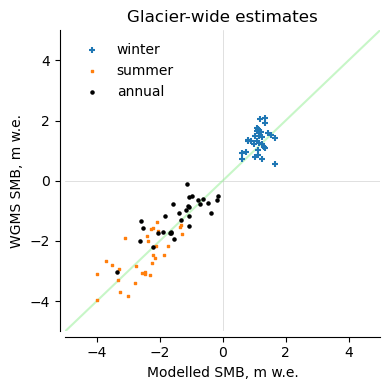

In [23]:
_, ax = plt.subplots(figsize=(4.0, 4.0))

ax.set_title("Glacier-wide estimates")

ax.axhline(y=0, color="lightgray", zorder=-2, linewidth=0.5)
ax.axvline(x=0, color="lightgray", zorder=-2, linewidth=0.5)
ax.plot([-100, 100], [-100, 100], color="lightgreen", alpha=0.5, zorder=-1)

ax.scatter(total_model["winter"], total_wgms["winter"], s=25, marker="+", color="C0", label="winter")
ax.scatter(total_model["summer"], total_wgms["summer"], s=4, marker="s", color="C1", label="summer")
ax.scatter(total_model["annual"], total_wgms["annual"], s=5, marker="o", color="black", label="annual", zorder=2)

ax.set_xlabel("Modelled SMB, m w.e.")
ax.set_ylabel("WGMS SMB, m w.e.")

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 4))
ax.spines["bottom"].set_position(("outward", 4))

ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()

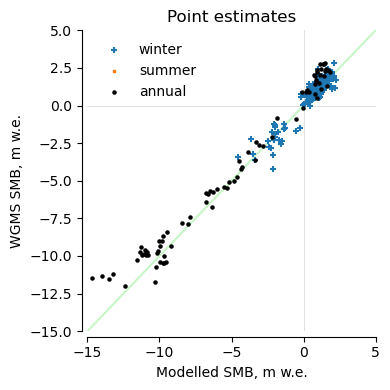

In [24]:
_, ax = plt.subplots(figsize=(4.0, 4.0))

ax.set_title("Point estimates")

ax.axhline(y=0, color="lightgray", zorder=-2, linewidth=0.5)
ax.axvline(x=0, color="lightgray", zorder=-2, linewidth=0.5)
ax.plot([-100, 100], [-100, 100], color="lightgreen", alpha=0.5, zorder=-1)

ax.scatter(point_model["winter"], point_wgms["winter"], s=25, marker="+", color="C0", label="winter")
ax.scatter(point_model["summer"], point_wgms["summer"], s=4, marker="s", color="C1", label="summer")
ax.scatter(point_model["annual"], point_wgms["annual"], s=5, marker="o", color="black", label="annual", zorder=2)

ax.set_xlabel("Modelled SMB, m w.e.")
ax.set_ylabel("WGMS SMB, m w.e.")

ax.set_xlim(-15, 5)
ax.set_ylim(-15, 5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_position(("outward", 4))
ax.spines["bottom"].set_position(("outward", 4))

ax.legend(frameon=False, loc="upper left")

plt.tight_layout()
plt.show()

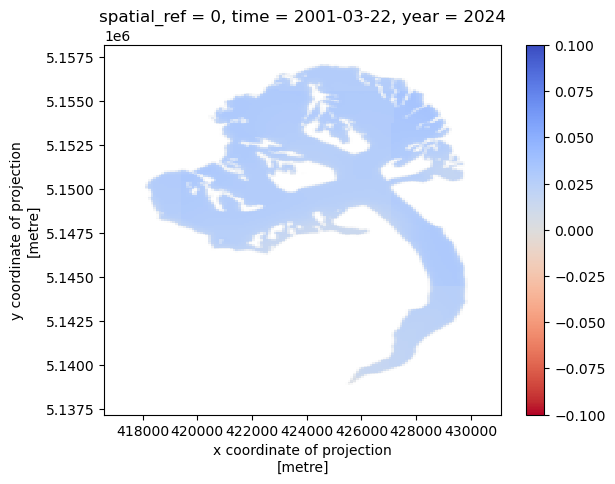

In [25]:
(smb_xr * yr_outlines)[2353].plot.imshow(vmin=-0.1, vmax=0.1, cmap="coolwarm_r", alpha=yr_outlines)

In [27]:
from matplotlib.animation import FFMpegWriter, FuncAnimation
import matplotlib_scalebar.scalebar

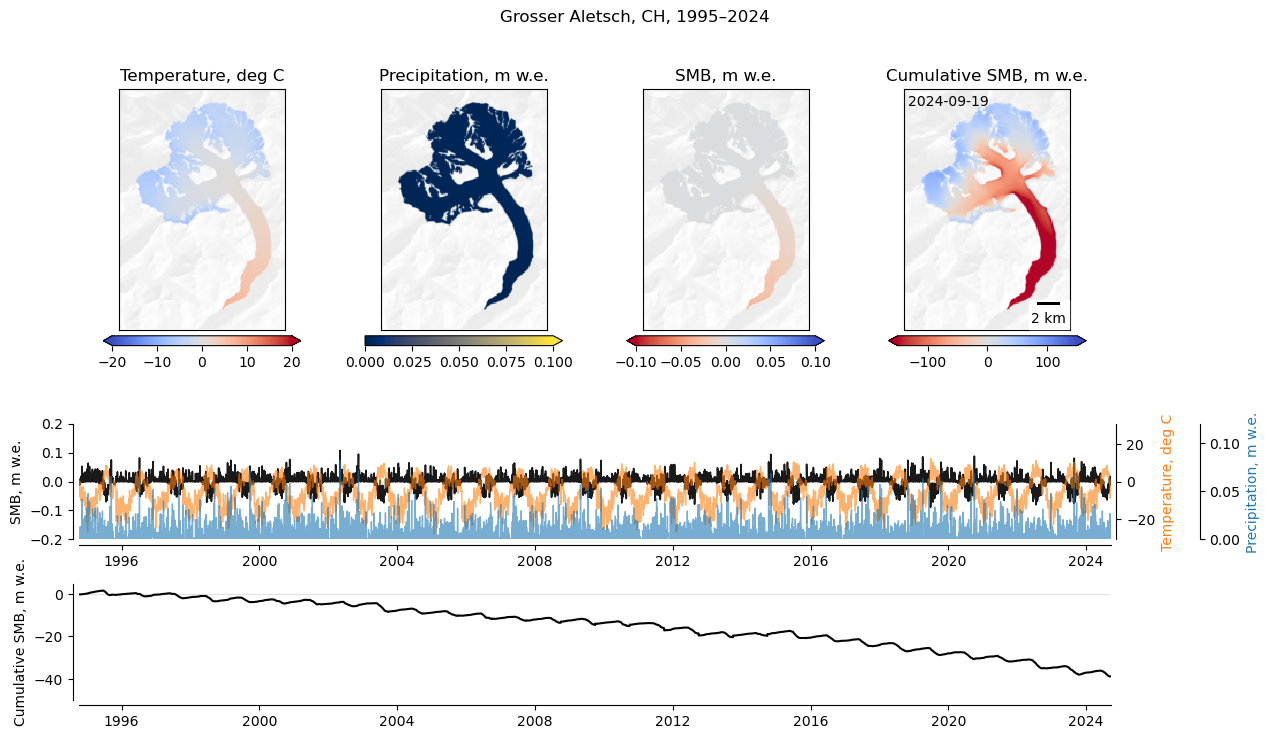

In [28]:
hillshade = rioxarray.open_rasterio(f"../../dirty/cop30dem/reprojected_to_hugonnet/derivatives/hillshade/{glacier['name']}.tif", masked=True)[0]

t_subset = temperature
p_subset = precipitation
outlines_subset = outlines
smb_subset = smb_xr
smb_subset_c = smb_subset.cumulative("time").sum()

time_vals = smb_subset["time"].values

t0 = t_subset[0]
p0 = p_subset[0]
outlines0 = outlines_subset[0]
smb_d0 = smb_subset[0]
smb_c0 = smb_subset_c[0]
t0_lbl = time_vals[0]
t0_lbl = pandas.to_datetime(t0_lbl)
lbl0 = f"{t0_lbl.year}-{t0_lbl.month:02d}-{t0_lbl.day:02d}"


fig = plt.figure(figsize=(12.8, 7.2))
gs = fig.add_gridspec(3, 4, height_ratios=[2.5, 1, 1], width_ratios=[1, 1, 1, 1])

ax_daily_smb = fig.add_subplot(gs[1, :])
ax_daily_t = ax_daily_smb.twinx()
ax_daily_p = ax_daily_smb.twinx()
ax_smb_cumulative = fig.add_subplot(gs[2, :])

for ax in [ax_daily_smb, ax_smb_cumulative, ax_daily_t, ax_daily_p]:
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_position(("outward", 4))
for ax in [ax_daily_smb, ax_smb_cumulative]:
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 4))
for ax in [ax_daily_t, ax_daily_p]:
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_position(("outward", 4))
ax_daily_p.spines["right"].set_position(("outward", 64))

ax_daily_smb.set_ylabel("SMB, m w.e.")
ax_daily_t.set_ylabel("Temperature, deg C", color="C1")
ax_daily_p.set_ylabel("Precipitation, m w.e.", color="C0")
ax_smb_cumulative.set_ylabel("Cumulative SMB, m w.e.")

ax_t = fig.add_subplot(gs[0, 0])
ax_p = fig.add_subplot(gs[0, 1])
ax_smb_d_im = fig.add_subplot(gs[0, 2])
ax_smb_c_im = fig.add_subplot(gs[0, 3])

ax_daily_smb.set_xlim(time_vals[0], time_vals[-1])
ax_daily_smb.set_ylim(-0.20, 0.20)
ax_daily_smb.axhline(y=0, color="lightgray", zorder=-2, linewidth=0.5)
ax_daily_t.set_ylim(-31, 31)
ax_daily_p.set_ylim(0, 0.12)
ax_smb_cumulative.set_xlim(time_vals[0], time_vals[-1])
ax_smb_cumulative.set_ylim(-50, 5)
ax_smb_cumulative.axhline(y=0, color="lightgray", zorder=-2, linewidth=0.5)

plt.suptitle(f"{glacier['name']}, CH, 1995–2024", y=1.02)

for ax in [ax_t, ax_p, ax_smb_d_im, ax_smb_c_im]:
    hillshade.plot.imshow(ax=ax, cmap="Grays", alpha=0.08, zorder=-1, add_colorbar=False)

(line_t,) = ax_daily_t.plot([time_vals[0]], [(t0 * outlines0).sum() / outlines0.sum()], color="C1", linewidth=1.0, alpha=0.6)
(line_p,) = ax_daily_p.plot([time_vals[0]], [(p0 * outlines0).sum() / outlines0.sum()], color="C0", linewidth=1.0, alpha=0.6)
(line_smb_d,) = ax_daily_smb.plot([time_vals[0]], [(smb_d0 * outlines0).sum() / outlines0.sum()], color="black", linewidth=1.2, alpha=0.9, zorder=2)

(line_smb_c,) = ax_smb_cumulative.plot([time_vals[0]], [(smb_c0 * outlines0).sum() / outlines0.sum()], color="black", linewidth=1.5)

im_t = t0.plot.imshow(
    ax=ax_t, cmap="coolwarm", vmin=-20, vmax=20, alpha=outlines0, 
    cbar_kwargs={"location": "bottom", "orientation": "horizontal", "shrink": 0.8, "pad": 0.02, "extend": "both", "label": None},
)
im_p = p0.plot.imshow(
    ax=ax_p, cmap="cividis", vmin=0, vmax=0.1, alpha=outlines0,
    cbar_kwargs={"location": "bottom", "orientation": "horizontal", "shrink": 0.8, "pad": 0.02, "extend": "max", "label": None},
)
im_smb_d = smb_d0.plot.imshow(
    ax=ax_smb_d_im, cmap="coolwarm_r", vmin=-0.1, vmax=0.1, alpha=outlines0,
    cbar_kwargs={"location": "bottom", "orientation": "horizontal", "shrink": 0.8, "pad": 0.02, "extend": "both", "label": None},
)
im_smb_c = smb_c0.plot.imshow(
    ax=ax_smb_c_im, cmap="coolwarm_r", vmin=-150, vmax=150, alpha=outlines0,
    cbar_kwargs={"location": "bottom", "orientation": "horizontal", "shrink": 0.8, "pad": 0.02, "extend": "both", "label": None},
)

lbl = ax_smb_c_im.text(0.02, 0.98, lbl0, va="top", ha="left", transform=ax_smb_c_im.transAxes)

ax_t.set_title("Temperature, deg C")
ax_p.set_title("Precipitation, m w.e.")
ax_smb_d_im.set_title("SMB, m w.e.")
ax_smb_c_im.set_title("Cumulative SMB, m w.e.")

for ax in [ax_t, ax_p, ax_smb_d_im, ax_smb_c_im]:
    ax.set_aspect(1)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
    # ax.axis("off")

scalebar = matplotlib_scalebar.scalebar.ScaleBar(1, loc="lower right")
ax_smb_c_im.add_artist(scalebar)

# pbar = tqdm(total=len(time_vals))

def update(i):
    # pbar.update(1)
    
    if i == 0:
        return []

    blit_artists = []
    
    ti = t_subset[i]
    pi = p_subset[i]
    smb_di = smb_subset[i]
    smb_ci = smb_subset_c[i]
    date = pandas.to_datetime(ti.time.values)
    year = date.year
    month = date.month
    day = date.day
    hydro_year = year + (1 if month >= 10 else 0)
    outlinesi = outlines_subset.sel(year=hydro_year)
    
    im_t.set_data(ti)
    im_p.set_data(pi)
    im_smb_d.set_data(smb_di)
    im_smb_c.set_data(smb_ci)
    for im in [im_t, im_p, im_smb_d, im_smb_c]:
        im.set_alpha(outlinesi)
        blit_artists.append(im)

    xi = time_vals[i]
    for line, arr in [(line_t, ti), (line_p, pi), (line_smb_d, smb_di), (line_smb_c, smb_ci)]:
        x, y = line.get_data()
        yi = (arr * outlinesi).sum() / outlinesi.sum()
        x = np.append(x, [xi])
        y = np.append(y, [yi])
        line.set_data(x, y)
        blit_artists.append(line)
    
    lbl.set_text(f"{year}-{month:02d}-{day:02d}")
    
    return blit_artists

# for i in range(len(time_vals)):
#     update(i)

plt.tight_layout()
# plt.show()



fps = 60
ani = FuncAnimation(fig, update, frames=list(range(len(time_vals))), interval=1000 // fps, blit=True)

writer = FFMpegWriter(
    fps=fps,
    metadata={"title": f"{glacier}_animation"},
    codec="libx264",
    extra_args=["-crf","14","-preset","veryslow","-pix_fmt","yuv420p","-movflags","+faststart","-tune","stillimage"],
)
ani.save(f"{glacier['name']}_animation_after_calibration.mp4", writer=writer, dpi=160)

fig.savefig(f"{glacier['name']}_lastframe_after_calibration.png", dpi=160, bbox_inches="tight", pad_inches=0.02)